In [1]:
import xarray as xr
import numpy as np

# User input

In [162]:
# directory with input data
diri = "/maloney-scratch/joedhsu/proj1/data/sst_locking/"

# input file name.  code assumes full time seires in single file
fili = "SPCCSM3.TS.daily.sample.nc"

# directory for output data
diro = "/maloney-scratch/joedhsu/proj1/data/sst_locking/"

# output filename prefix (usually includes model and/or simulation details)
prefix = "SPCCSM"

# time coordinate variable name
timeName = "time" # units should be similar to "days since YYYY-MM-DD" or "hours since YYYY-MM-DD-HH:MM"

# longitude coordinate variable name
lonName = "lon"

# latitude coordinate variable name
latName = "lat"

#  surface temperature or equivalent variable name
varName = "TS"

#  number of days per year (typically 365, sometimes 360)
DaysPerYear = 365 # some models have 360-day years.  Use 365 if Leap Days included

# Data IO

In [176]:
ds = xr.open_dataset(diri+fili,use_cftime=True)

# Land masking

In [177]:
from ocean_mask import ocn_mask
 
da_omask_regrid = ocn_mask(ds[varName])
da_lmask_regrid = da_omask_regrid.where(da_omask_regrid.notnull(),other=2)-1
da_lmask_regrid = da_lmask_regrid.where(da_lmask_regrid==1, other=0)

/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


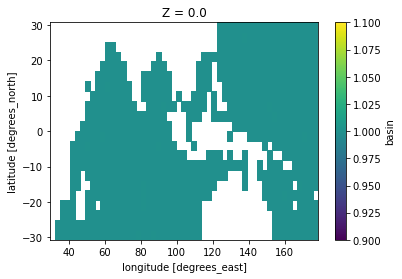

In [178]:
da_omask_regrid.plot()

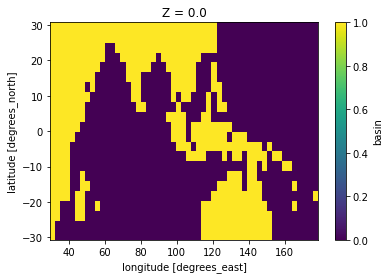

In [179]:
da_lmask_regrid.plot()

In [182]:
ds['%s_ocn'%varName] = ds[varName]*da_omask_regrid

# Calculate background signal

In [183]:
import importlib
import lanczos_filter
importlib.reload(lanczos_filter)
import lanczos_filter as lf

ds['%s_ocn_mean'%varName] = ds['%s_ocn'%varName].mean(dim=timeName)
ds['%s_ocn_nomean'%varName] = ds['%s_ocn'%varName]-ds['%s_ocn_mean'%varName]
ds['%s_ocn_bg'%varName] = lf.lanczos_low_pass(ds['%s_ocn_nomean'%varName], 201, 1/100., dim=timeName,opt='symm')+ds['%s_ocn_mean'%varName]
ds['%s_ocn_anom'%varName] = ds['%s_ocn'%varName]-ds['%s_ocn_bg'%varName]

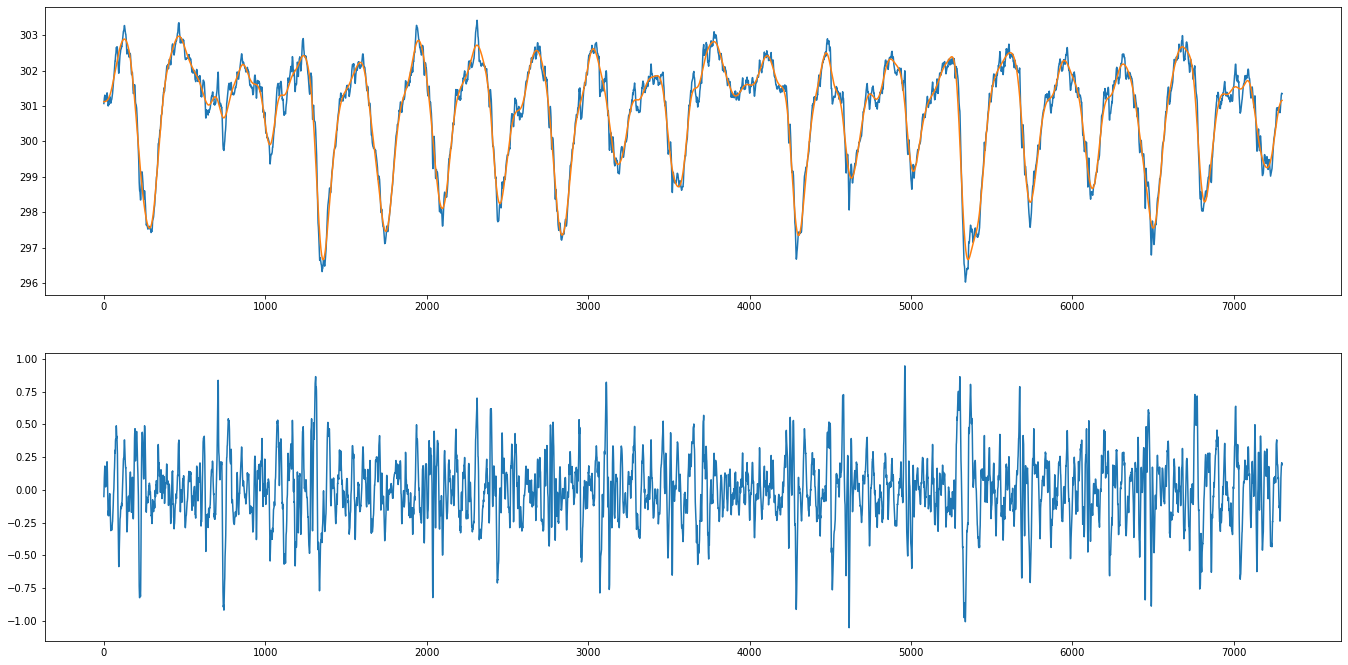

In [173]:
import matplotlib.pyplot as plt

#### plotting
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
da_ori = ds['%s_ocn'%varName].isel(lon=20,lat=10)
da_test = ds['%s_ocn_bg'%varName].isel(lon=20,lat=10)
ax1.plot(da_ori.values)
ax1.plot(da_test.values)
ax2=fig.add_axes([0,-1.2,3,1])
da_ori = ds['%s_ocn_anom'%varName].isel(lon=20,lat=10)
ax2.plot(da_ori.values)

In [174]:
ds = ds.transpose(latName,lonName,timeName)

# Random Pattern

In [138]:
import random

da_randpatt = ds['%s_ocn_anom'%varName].copy()*np.nan

In [139]:
%%time
for i in range(1,DaysPerYear+1):
    dayindex = np.where(ds['%s.dayofyear'%timeName].values==i)[0]
    newindex = np.copy(dayindex)
    random.shuffle(dayindex)
    da_randpatt[:,:,list(newindex)] = ds['%s_ocn_anom'%varName][:,:,list(dayindex)].values

CPU times: user 6.9 s, sys: 1e+03 ns, total: 6.9 s
Wall time: 6.9 s


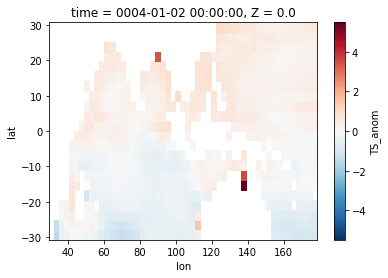

In [140]:
ds['%s_ocn_anom'%varName].isel(time=1).plot()

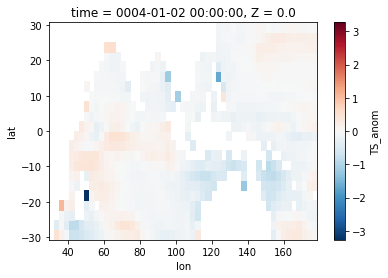

In [141]:
da_randpatt.isel(time=1).plot()

# Random single point

In [154]:
import random

da_randpt = ds['%s_ocn_anom'%varName].copy()*np.nan

In [ ]:
%%time

for i in range(len(ds['%s'%lonName])):
    print("swapping pointwise on lon index %i"i)
    for j in range(len(ds['%s'%latName])):
        for ii in range(1,DaysPerYear+1):
            dayindex = np.where(ds['%s.dayofyear'%timeName].values==ii)[0]
            newindex = np.copy(dayindex)
            random.shuffle(dayindex)
            da_randpt[j,i,list(newindex)] = ds['%s_ocn_anom'%varName][j,i,list(dayindex)].values

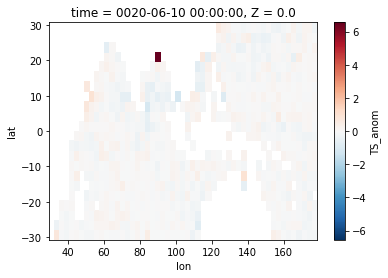

In [189]:
da_randpt.isel(time=6000).plot()

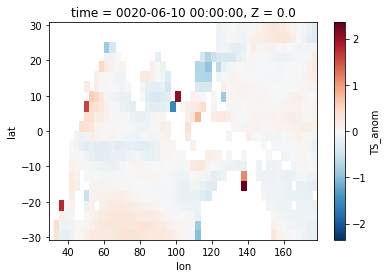

In [160]:
ds['%s_ocn_anom'%varName].isel(time=6000).plot()

# Random 5days

In [143]:
da_randpatt5days = ds['%s_ocn_anom'%varName].copy()*np.nan

In [144]:
%%time
for i in range(1,DaysPerYear+1,5):
    dayindex = np.where(ds['%s.dayofyear'%timeName].values==i)[0]
    newindex = np.copy(dayindex)
    random.shuffle(dayindex)
    for newind,oldind in enumerate(dayindex):
        da_randpatt5days[:,:,newindex[newind]:newindex[newind]+5] = ds['%s_ocn_anom'%varName][:,:,oldind:oldind+5].values


CPU times: user 2.5 s, sys: 2 µs, total: 2.5 s
Wall time: 2.5 s


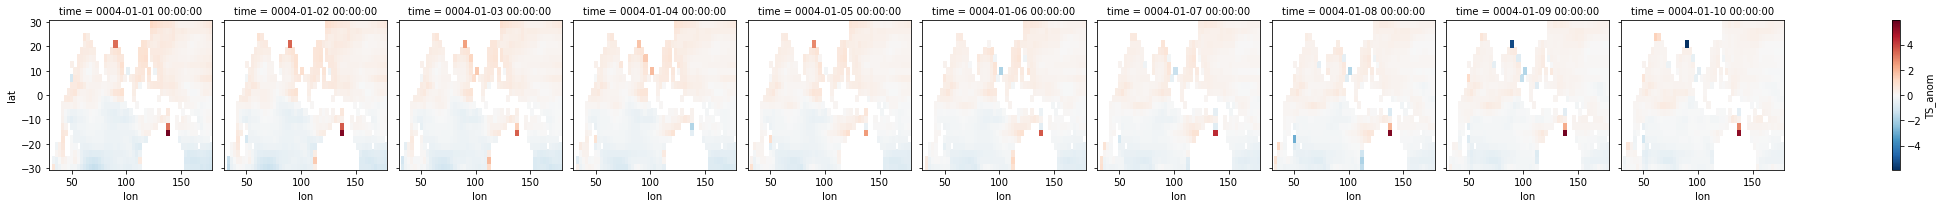

In [145]:
ds['%s_ocn_anom'%varName].isel(time=np.arange(0,10)).plot(col='time')

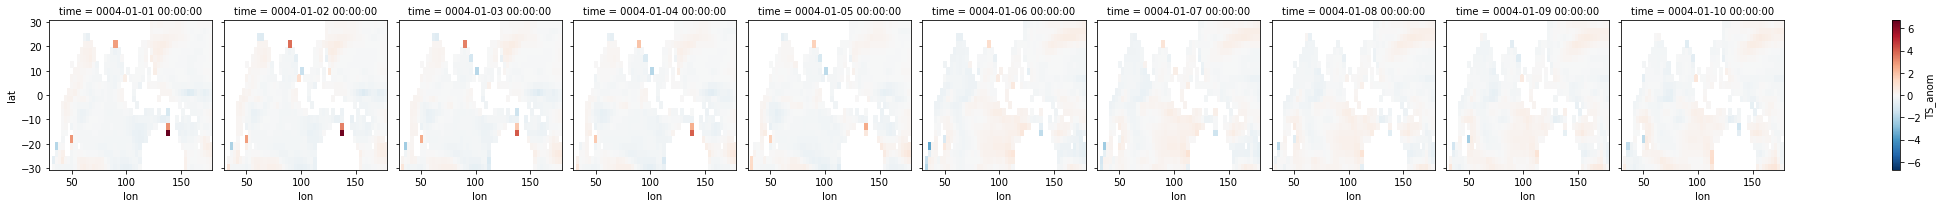

In [147]:
da_randpatt5days.isel(time=np.arange(0,10)).plot(col='time')

# Putting Land points back

In [185]:
ds['RandPatt1d'] = (da_randpatt+ds['%s_ocn_bg'%varName])
ds['RandPt1d'] = (da_randpt+ds['%s_ocn_bg'%varName])
ds['RandPatt5d'] = (da_randpatt5days+ds['%s_ocn_bg'%varName])

ds['RandPatt1d'] = ds['RandPatt1d'].where(ds['RandPatt1d'].notnull(),other=0.)
ds['RandPt1d'] = ds['RandPt1d'].where(ds['RandPt1d'].notnull(),other=0.)
ds['RandPatt5d'] = ds['RandPatt5d'].where(ds['RandPatt5d'].notnull(),other=0.)

ds['RandPatt1d'] = da_lmask_regrid*ds['%s'%varName]+ds['RandPatt1d']
ds['RandPt1d'] = da_lmask_regrid*ds['%s'%varName]+ds['RandPt1d']
ds['RandPatt5d'] = da_lmask_regrid*ds['%s'%varName]+ds['RandPatt5d']

# Demo plots

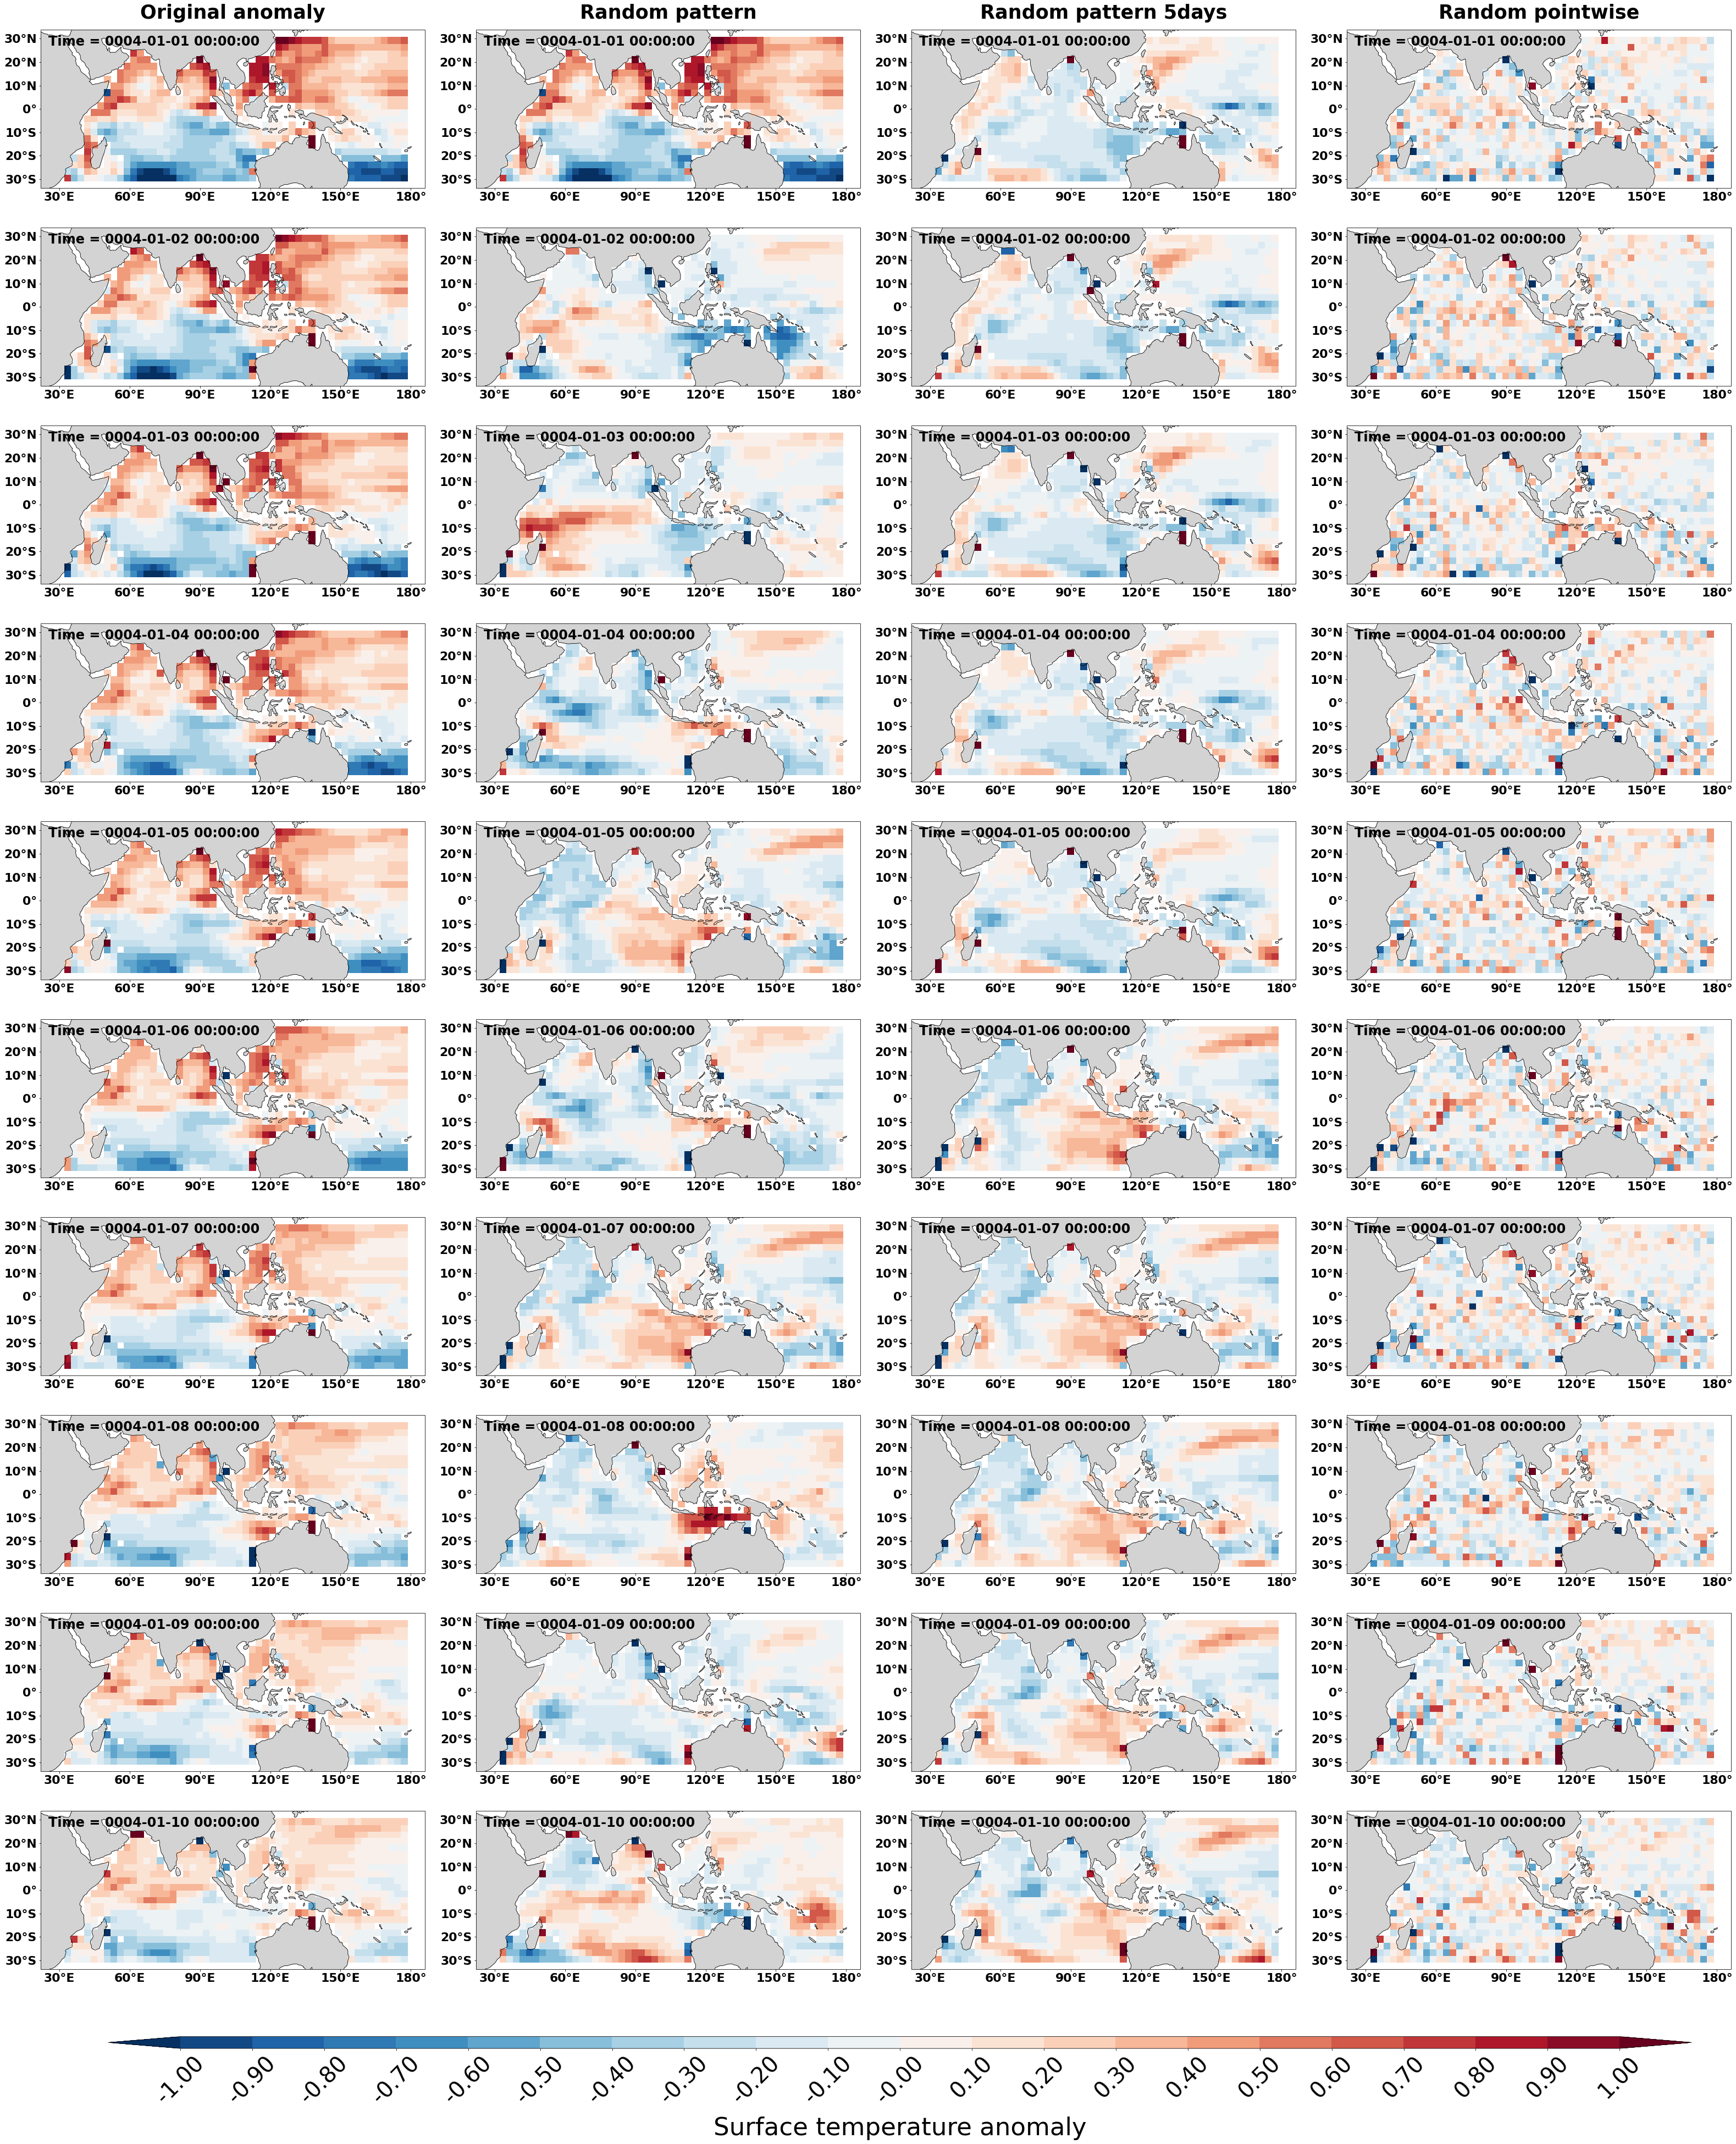

In [205]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# from palettable.colorbrewer.diverging import BrBG_11

fig = plt.figure(2,figsize=(20,10))
devy = 0.5
dlevel = np.arange(-1, 1+0.01, 0.1)
timeindex = np.arange(0,10)


######################################## plotting ############################################
for nindex,timeindex in enumerate(timeindex):
    
    #### original ####
    ax2 = fig.add_axes([0,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['%s_ocn_anom'%varName].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([30,60,90,120,150,180], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([30,60,90,120,150,180], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Original anomaly', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')
    
    
    #### random pattern ####
    ax2 = fig.add_axes([0+0.55,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpatt.isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([30,60,90,120,150,180], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([30,60,90,120,150,180], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pattern 5days ####
    ax2 = fig.add_axes([0+0.55*2,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpatt5days.isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([30,60,90,120,150,180], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([30,60,90,120,150,180], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern 5days', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pointwise ####
    ax2 = fig.add_axes([0+0.55*3,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpt.isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([30,60,90,120,150,180], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([30,60,90,120,150,180], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pointwise', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')



cbaxes=fig.add_axes([0+0.4,0-nindex*devy-0.6,2,0.03])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.2f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=40,rotation=45) 
cbar.set_label(label='Surface temperature anomaly',size=45, labelpad=15)



fig.savefig('../figure/SST_locking_anom_demo.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', format=None,
                transparent=False, bbox_inches="tight", pad_inches=None)



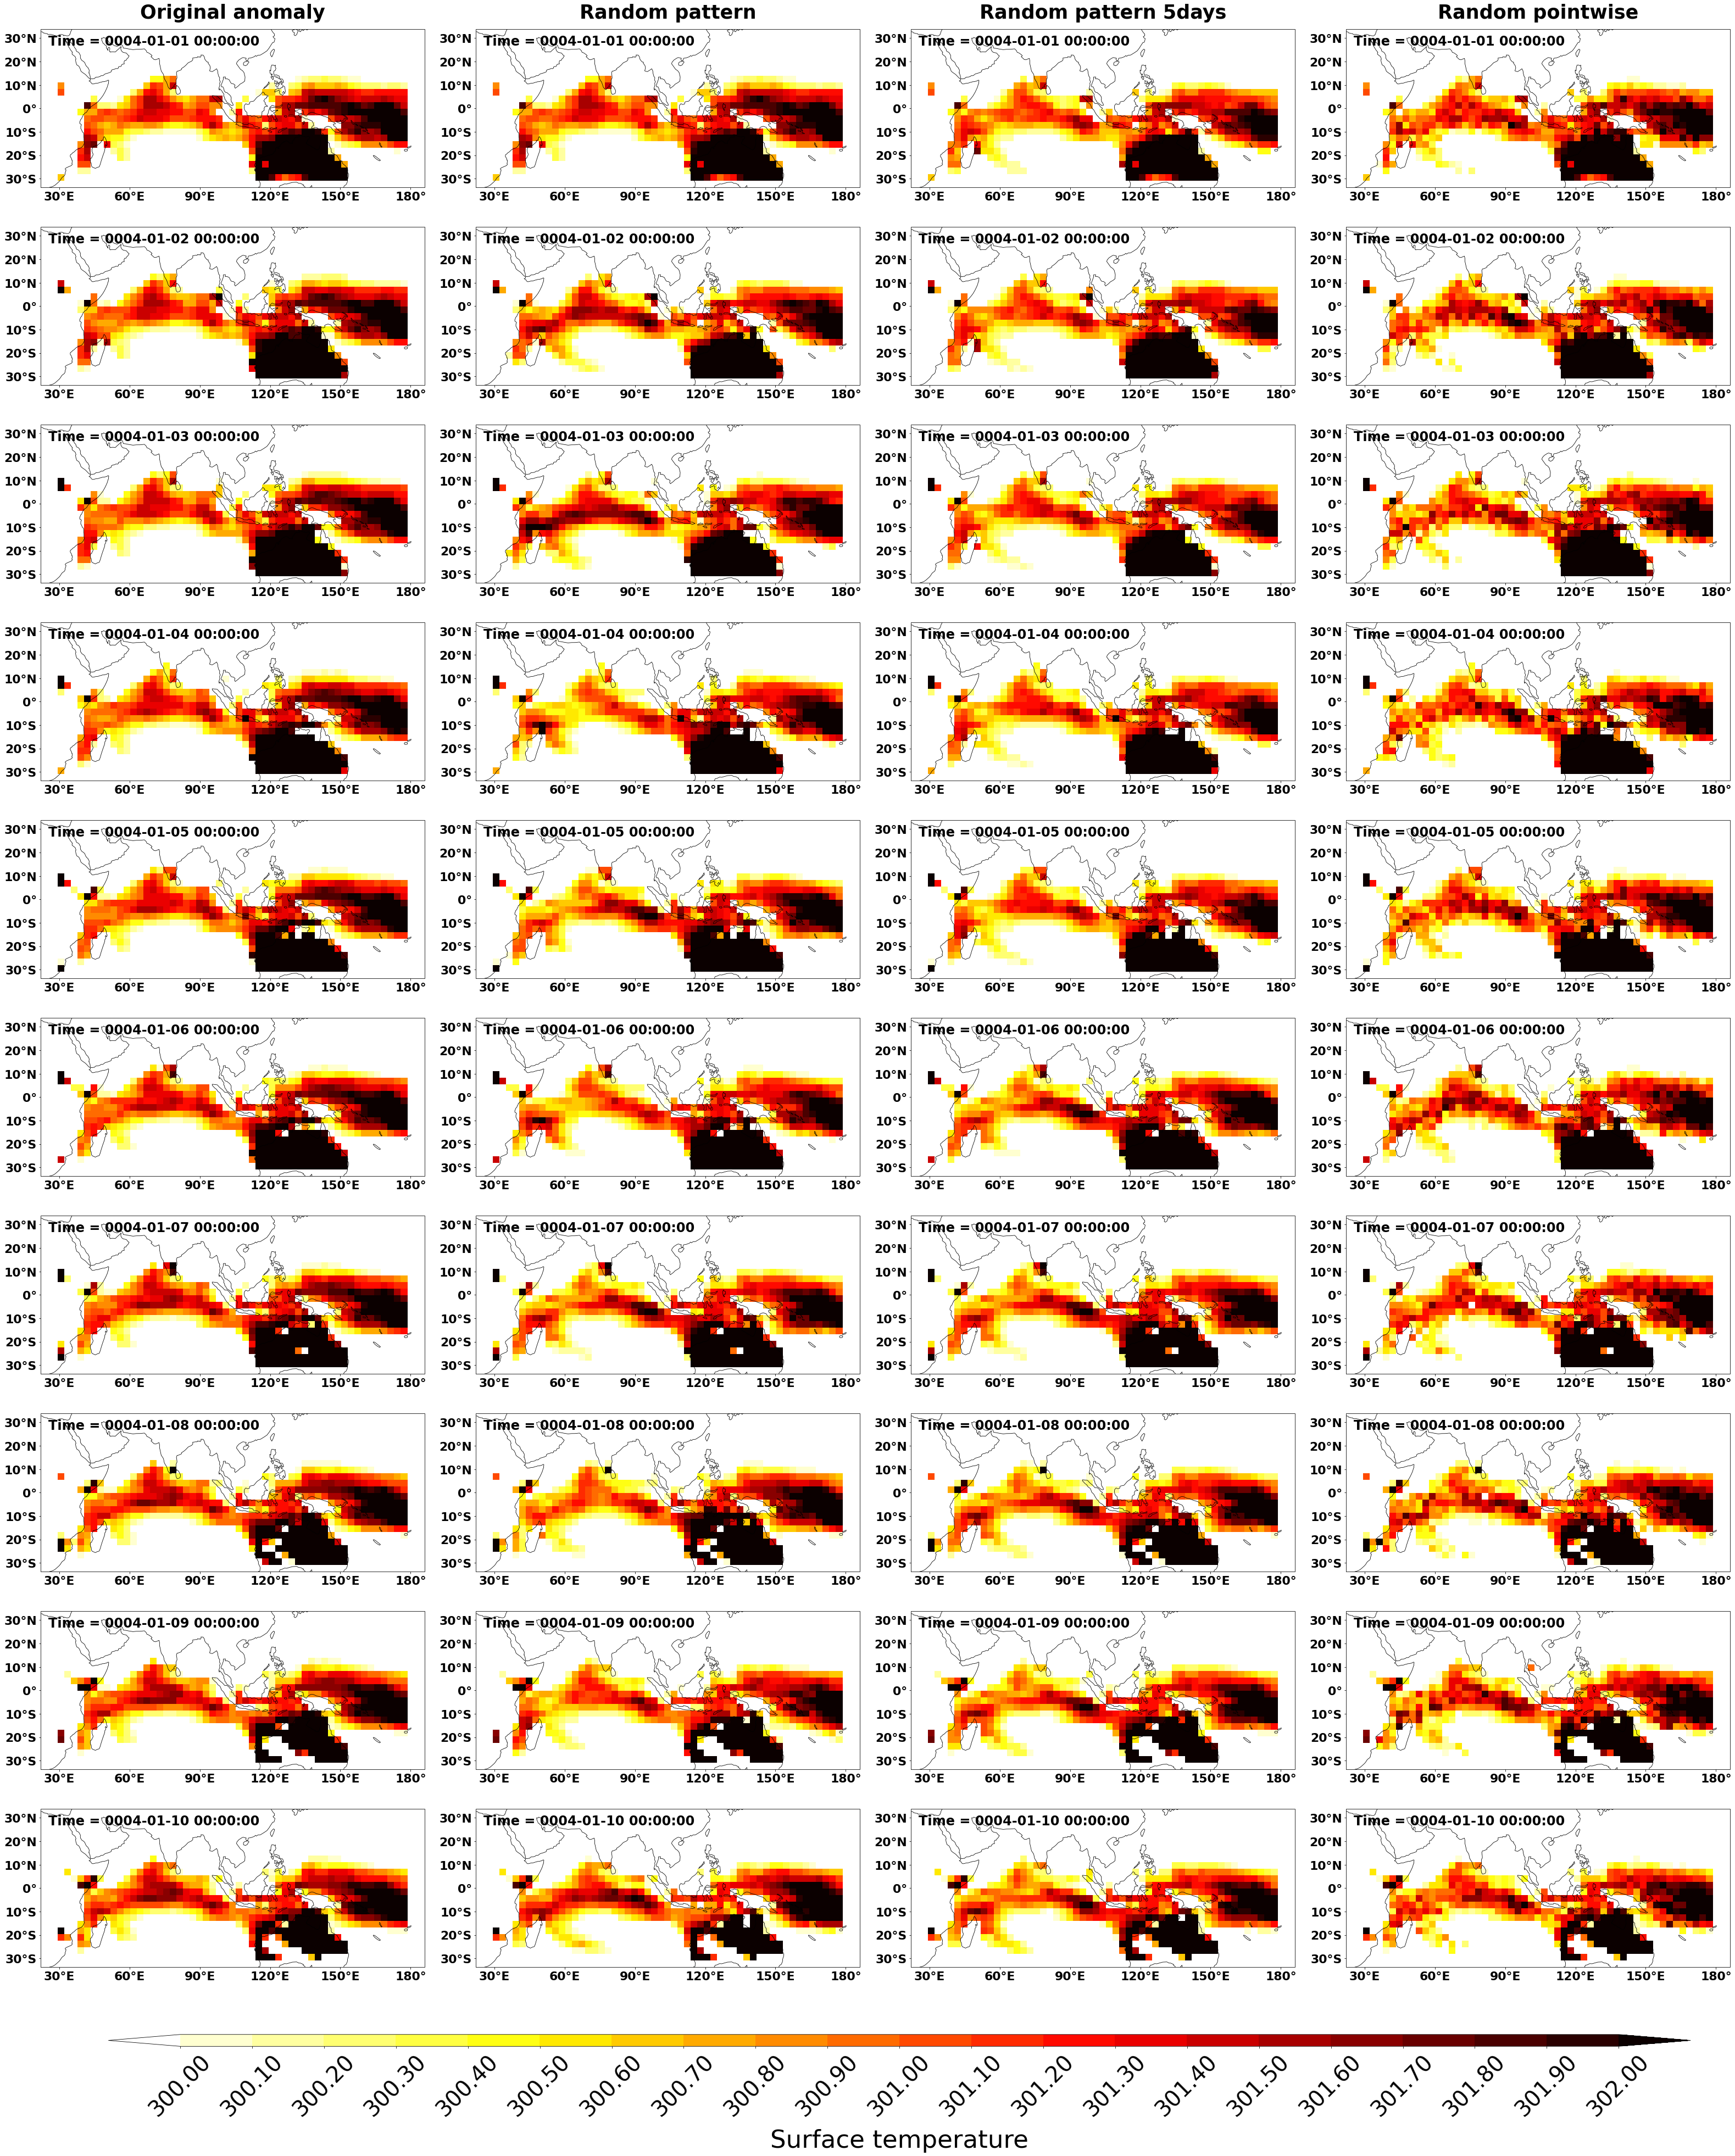

In [209]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# from palettable.colorbrewer.diverging import BrBG_11

fig = plt.figure(2,figsize=(20,10))
devy = 0.5
dlevel = np.arange(300, 302+0.01, 0.1)
timeindex = np.arange(0,10)


######################################## plotting ############################################
for nindex,timeindex in enumerate(timeindex):
    
    #### original ####
    ax2 = fig.add_axes([0,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['%s'%varName].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='hot_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
#     ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([30,60,90,120,150,180], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([30,60,90,120,150,180], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Original anomaly', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')
    
    
    #### random pattern ####
    ax2 = fig.add_axes([0+0.55,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['RandPatt1d'].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='hot_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
#     ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([30,60,90,120,150,180], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([30,60,90,120,150,180], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pattern 5days ####
    ax2 = fig.add_axes([0+0.55*2,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['RandPatt5d'].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='hot_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
#     ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([30,60,90,120,150,180], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([30,60,90,120,150,180], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern 5days', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pointwise ####
    ax2 = fig.add_axes([0+0.55*3,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['RandPt1d'].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='hot_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
#     ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([30,60,90,120,150,180], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([30,60,90,120,150,180], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pointwise', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')



cbaxes=fig.add_axes([0+0.4,0-nindex*devy-0.6,2,0.03])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.2f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=40,rotation=45) 
cbar.set_label(label='Surface temperature',size=45, labelpad=15)



fig.savefig('../figure/SST_locking_total_demo.pdf', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', format=None,
                transparent=False, bbox_inches="tight", pad_inches=None)

